### Radiomics with Medical Information

In this notebook we apply the same methodology as for radiomics, but now including the medical information provided by the UKBB. 

As contrary from the ACDC dataset, for the UKBB we have up to 17 different fields regarding patient's information related to:

* Exercise
* Age
* Smoking levels
* Education Levels
* Sex
* Diabetes
* Poverty

and more that it is hoped to support the models in the separability task in the diseases.

In this notebook is shown how this information is handled and the results.

In [1]:
### import the packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_score, roc_auc_score, roc_curve, recall_score
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFECV, RFE
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import seaborn as sns
from tabulate import tabulate
# from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
train_df = pd.read_csv('_angina_tot_med.csv')
# train_df = stratified_sample_df(train_df, 'class', 780)

train_df = train_df.loc[:,~ train_df.columns.str.startswith('diagnostics')]
id_list = train_df['f.eid']
# id_list.to_csv('id_list_long.txt')
train_df = train_df.drop(['Unnamed: 0', 'f.eid'], axis=1)

print(train_df.shape)

y_train_df = train_df['class']

#ED_train_df = train_df.filter(regex='ED')
#ES_train_df = train_df.filter(regex='ES')

rad_train = train_df.iloc[:,:-1]

(800, 705)


In [2]:
rad_train.iloc[0:10,0:15]

,con_red,con_proc_meat,con_pork,con_oilyFish,con_lamb,con_beef,cov_age,cov_sex,cov_smoker,cov_deprivation,cov_log_bmi,cov_alcohol,cov_log_exercise,cov_diabetes,cov_hypertens
0,0.21428,0.32143,0.05357,0.32143,0.10714,0.05357,45,1,0,-4.876990,3.274012,4,7.457609,0.0,0
1,0.16071,0.05357,0.05357,0.05357,0.05357,0.05357,65,1,0,-5.695500,3.314978,5,7.234898,0.0,1
2,0.26785,0.10714,0.05357,0.10714,0.10714,0.10714,64,0,0,-2.781220,3.192162,4,8.939450,0.0,0
3,0.16071,0.32143,0.05357,0.05357,0.05357,0.05357,64,1,0,-4.137370,3.292239,5,8.721439,0.0,0
4,0.21428,0.10714,0.05357,0.10714,0.05357,0.10714,45,1,0,-3.474390,3.032185,3,6.489965,0.0,0
5,0.16071,0.10714,0.05357,0.10714,0.05357,0.05357,48,0,0,-3.577400,3.308350,5,8.095599,0.0,0
6,0.42857,0.32143,0.05357,0.05357,0.05357,0.32143,45,1,0,-2.932440,3.202482,5,6.191339,0.0,0
7,0.16071,0.10714,0.05357,0.00000,0.05357,0.05357,60,1,1,-0.516125,3.300081,5,8.019613,0.0,0
8,0.16071,0.10714,0.05357,0.10714,0.05357,0.05357,53,1,0,-3.217200,3.484529,3,5.424950,0.0,1
9,0.32142,0.05357,0.10714,0.10714,0.10714,0.10714,60,0,0,-2.671790,3.265805,2,6.829794,0.0,1


In [3]:
rad_train.columns[0:17]

Index(['con_red', 'con_proc_meat', 'con_pork', 'con_oilyFish', 'con_lamb',
       'con_beef', 'cov_age', 'cov_sex', 'cov_smoker', 'cov_deprivation',
       'cov_log_bmi', 'cov_alcohol', 'cov_log_exercise', 'cov_diabetes',
       'cov_hypertens', 'cov_highchol', 'cov_educ'],
      dtype='object')

In [60]:
for col in rad_train.columns:
    print(col)
    print(rad_train[col].isna().sum())

con_red
0
con_proc_meat
0
con_pork
1
con_oilyFish
0
con_lamb
1
con_beef
0
cov_age
0
cov_sex
0
cov_smoker
0
cov_deprivation
2
cov_log_bmi
1
cov_alcohol
0
cov_log_exercise
1
cov_diabetes
1
cov_hypertens
0
cov_highchol
0
cov_educ
2
cmr_LVEDV_i
1
cmr_LVESV_i
1
cmr_LVSV_i
1
cmr_LVM_i
1
cmr_LVEF
0
cmr_RVEDV_i
309
cmr_RVESV_i
309
cmr_RVSV_i
309
cmr_RVEF
308
Volume_LV_ED
0
SurfaceArea_LV_ED
0
SurfaceAreatoVolumeRatio_LV_ED
0
Sphericity_LV_ED
0
SphericalDisproportion_LV_ED
0
Compactness_LV_ED
0
Compactness2_LV_ED
0
Max3Ddiameter_LV_ED
0
Max2DdiameterSlice_LV_ED
0
Max2DdiameterColumn_LV_ED
0
Max2DdiameterRow_LV_ED
0
MajorAxis_LV_ED
0
MinorAxis_LV_ED
0
LeastAxis_LV_ED
0
Elongation_LV_ED
0
Flatness_LV_ED
0
Volume_LV_ES
0
SurfaceArea_LV_ES
0
SurfaceAreatoVolumeRatio_LV_ES
0
Sphericity_LV_ES
0
SphericalDisproportion_LV_ES
0
Compactness_LV_ES
0
Compactness2_LV_ES
0
Max3Ddiameter_LV_ES
0
Max2DdiameterSlice_LV_ES
0
Max2DdiameterColumn_LV_ES
0
Max2DdiameterRow_LV_ES
0
MajorAxis_LV_ES
0
MinorAxis_LV_ES
0

In [61]:
rad_train.head()

,con_red,con_proc_meat,con_pork,con_oilyFish,con_lamb,con_beef,cov_age,cov_sex,cov_smoker,cov_deprivation,...,DependenceNonUniformityNormalized_gldm_MYO_ES,GrayLevelVariance_gldm_MYO_ES,DependenceVariance_gldm_MYO_ES,DependenceEntropy_gldm_MYO_ES,LowGrayLevelEmphasis_gldm_MYO_ES,HighGrayLevelEmphasis_gldm_MYO_ES,SmallDependenceLowGrayLevelEmphasis_gldm_MYO_ES,SmallDependenceHighGrayLevelEmphasis_gldm_MYO_ES,LargeDependenceLowGrayLevelEmphasis_gldm_MYO_ES,LargeDependenceHighGrayLevelEmphasis_gldm_MYO_ES
0,0.21428,0.32143,0.05357,0.32143,0.10714,0.05357,45,1,0,-4.87699,...,0.045827,0.410879,38.049748,5.683738,0.089275,13.459016,0.004913,0.506779,15.885040,2807.541878
1,0.16071,0.05357,0.05357,0.05357,0.05357,0.05357,65,1,0,-5.69550,...,0.043626,0.380344,39.526991,5.701656,0.133112,9.173106,0.005724,0.282039,25.057670,2071.294699
2,0.26785,0.10714,0.05357,0.10714,0.10714,0.10714,64,0,0,-2.78122,...,0.046251,0.315007,39.011615,5.455397,0.244790,5.337112,0.009174,0.287529,50.174805,993.581567
3,0.16071,0.32143,0.05357,0.05357,0.05357,0.05357,64,1,0,-4.13737,...,0.043090,0.321625,41.693987,5.568289,0.289766,4.883359,0.016327,0.186144,50.957714,973.859513
4,0.21428,0.10714,0.05357,0.10714,0.05357,0.10714,45,1,0,-3.47439,...,0.046345,0.455542,35.396728,5.644355,0.098938,11.971578,0.005307,0.525834,20.323454,2238.026672


We are dropping fields related to the patient's dietic habits and cmr indices that are hand crafted radiomics features calculated from the images. 

In [62]:
rad_train= rad_train.drop(['con_red', 'con_proc_meat', 'con_pork', 'con_oilyFish', 'con_lamb',
       'con_beef','cmr_LVEDV_i', 'cmr_LVESV_i', 'cmr_LVSV_i',
       'cmr_LVM_i', 'cmr_LVEF', 'cmr_RVEDV_i', 'cmr_RVESV_i', 'cmr_RVSV_i',
       'cmr_RVEF'], axis=1)

In [63]:
rad_train.isna().sum().sum()

7

In [55]:
for col in rad_train.columns:
    print(col)
    print(rad_train[col].isna().sum())

cov_age
0
cov_sex
0
cov_smoker
0
cov_deprivation
2
cov_log_bmi
1
cov_alcohol
0
cov_log_exercise
1
cov_diabetes
1
cov_hypertens
0
cov_highchol
0
cov_educ
2
Volume_LV_ED
0
SurfaceArea_LV_ED
0
SurfaceAreatoVolumeRatio_LV_ED
0
Sphericity_LV_ED
0
SphericalDisproportion_LV_ED
0
Compactness_LV_ED
0
Compactness2_LV_ED
0
Max3Ddiameter_LV_ED
0
Max2DdiameterSlice_LV_ED
0
Max2DdiameterColumn_LV_ED
0
Max2DdiameterRow_LV_ED
0
MajorAxis_LV_ED
0
MinorAxis_LV_ED
0
LeastAxis_LV_ED
0
Elongation_LV_ED
0
Flatness_LV_ED
0
Volume_LV_ES
0
SurfaceArea_LV_ES
0
SurfaceAreatoVolumeRatio_LV_ES
0
Sphericity_LV_ES
0
SphericalDisproportion_LV_ES
0
Compactness_LV_ES
0
Compactness2_LV_ES
0
Max3Ddiameter_LV_ES
0
Max2DdiameterSlice_LV_ES
0
Max2DdiameterColumn_LV_ES
0
Max2DdiameterRow_LV_ES
0
MajorAxis_LV_ES
0
MinorAxis_LV_ES
0
LeastAxis_LV_ES
0
Elongation_LV_ES
0
Flatness_LV_ES
0
Volume_RV_ED
0
SurfaceArea_RV_ED
0
SurfaceAreatoVolumeRatio_RV_ED
0
Sphericity_RV_ED
0
SphericalDisproportion_RV_ED
0
Compactness_RV_ED
0
Compa

We acknowledge that there exist some nan values. For this case, we are not going to drop this rows as we need to mantain the number of patients for the final comparison. Instead, we fill this nan values with 0s.

In [64]:
### Fill the rows with nan values. We can afford this due to the large dataset we have

rad_train = rad_train.fillna(0)

In [65]:
rad_train.isna().sum().sum()

0

We also assign dummy labels to the field education, since this is a categorical feature.

In [66]:
rad_train = pd.get_dummies(rad_train, columns=['cov_educ'])

In [67]:
count = 0
drop_list = list()
for col in rad_train.dtypes:
    if col == 'object':
        drop_list.append(count)
    count +=1

In [68]:
len(drop_list)

48

Deprecated columns

In [69]:
rad_train = rad_train.drop(rad_train.columns[drop_list], axis = 1)

rad_train.shape

(800, 646)

In [70]:
list(train_df['class'].unique())

['HEALTHY', 'ANGINA']

In [72]:
train_df['class'].value_counts()

ANGINA     400
HEALTHY    400
Name: class, dtype: int64

In [81]:
class_list= list(y_train_df.unique())

In [77]:
encoder= LabelEncoder()
class_list2 = encoder.fit_transform(class_list)

In [78]:
class_list2

array([1, 0], dtype=int64)

In [101]:
def KBest_GS(X_train, y_train, X_test, y_test, model, param_grid, x_df):
    
    selector = SelectKBest()
    
    ### Pipeline
    
    ### we would need to adapt the "NUMBER OF FEATURES PARAMETER OF THE GRID"
    
    pipe = Pipeline([('selector', selector), 
                 ('model', model)])

    featss = np.array(range(5,X_train.shape[1]))
    featss = np.array(range(5,20))

    dict_1 = {'selector__score_func': [f_classif, chi2],
              'selector__k':featss}   #### para pruebas
    
    dict_1.update(param_grid)
    
    gs = GridSearchCV(estimator=pipe, 
                  param_grid=dict_1, 
                  scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'], 
                  n_jobs=1, 
                  cv=StratifiedKFold(3, shuffle=True, random_state=42),
                  refit='accuracy',
                verbose=1)
    
    print(pipe.get_params().keys())
    
    gs = gs.fit(X_train, y_train)
    
    print("Best Model", gs.best_params_)
    
    print('Best score:', gs.best_score_)
    
    y_test_pred = gs.predict(X_test)
    
    test_acc = accuracy_score(y_test,y_test_pred)
    probs=gs.predict_proba(X_test_p)
    probs = probs[:, 1]
    ROC_AUC = roc_auc_score(y_test, probs)
    precison_scor = precision_score(y_test,y_test_pred)
    recall_scor = recall_score(y_test, y_test_pred)
    
    fpr, tpr, thresholds = roc_curve(y_testp, probs)
    
    print("\n Test Accuracy with best estimator: ", test_acc)
    print("\n Roc AUC with best estimator: ", ROC_AUC)
    print("\n Precision with best estimator: ", precison_scor)
    print("\n Recall with best estimator: ", recall_scor, "\n")
    
    
    l = [[test_acc, ROC_AUC, precison_scor, recall_scor]]
    table = tabulate(l, headers=['Accuracy', 'ROC_AUC', 'Precision', 'Recall'], tablefmt='orgtbl')
    
    print(table)
    
    cm = confusion_matrix(y_test, y_test_pred)
        
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig = plt.figure(figsize=(10,4))
    fig.add_subplot(121)
#     plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()

    tick_marks = np.arange(len(class_list))
    plt.xticks(tick_marks+0.5, class_list, rotation=45)
    plt.yticks(tick_marks+0.5, class_list)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    fig.add_subplot(122)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.tight_layout()

    plt.show()

    print(classification_report(y_test, y_test_pred,target_names=class_list))
    
    cols = gs.best_estimator_.steps[0][1].get_support(indices=True)
    features_df_new = x_df.iloc[:,cols]
    K_best = list(features_df_new.columns)
    
    print(K_best)
    
    return gs, K_best
    

def processing(X_train,y_train, X_test, y_test):
    #tools scaling and labelling
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
#     y_train = encoder.fit_transform(y_train)
#     y_test = encoder.fit_transform(y_test)
    
    return X_train, y_train, X_test, y_test

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

#Support Vector Classifier

model_SVC = SVC(gamma = 'scale', probability=True, max_iter= 5000, random_state=42)

param_grid_SVC =  {'model__kernel':('linear', 'rbf'), 
                   'model__C':[0.3, 0.5, 1,5, 10]}

# param_grid_SVC_nested =  { 'sfs__estimator__kernel': ['linear', 'rbf', 'poly']},
#                           {'degree':[1,5,10]},{
#                    'sfs__estimator__C':[5]}

param_grid_SVC_nested_2 =  { 'selector__estimator__kernel': ['linear', 'rbf'],
                   'selector__estimator__C':[15]}

param_grid_SVC_test_2 =  { 
                   'estimator__model__C':[0.5, 1,5,10]}


#-------------------------------------------------------

#Random Forest 

# Number of trees in random forest
n_estimators = [10, 100,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4,6,8,10]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

# param_grid_RF = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

param_grid_RF = {'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}

param_grid_RF_2 = {'estimator__n_estimators': n_estimators,
               'estimator__bootstrap': bootstrap}

model_RF = RandomForestClassifier(random_state=42)

#--------------------------------------------------------------

# Logistic Regression

param_grid_LR_nested = {'model__penalty': ['l1','l2'], 
               'model__C': [0.1,1,10,100, 200]}

param_grid_LR = {'penalty': ['l1','l2'], 
               'C': [0.1,1,10,100, 200]}

model_LR = LogisticRegression( multi_class='auto', random_state=42)

#-------------------------------------------------------------------


In [92]:
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(rad_train)

In [93]:
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y_train_df)

In [94]:
X_train_p, X_test_p, y_trainp, y_testp = train_test_split(X_sc, y_enc, test_size=100,
                                                   shuffle=True,
                                                    stratify=y_train_df,
                                                   random_state=42)

dict_keys(['memory', 'steps', 'verbose', 'selector', 'model', 'selector__k', 'selector__score_func', 'model__C', 'model__break_ties', 'model__cache_size', 'model__class_weight', 'model__coef0', 'model__decision_function_shape', 'model__degree', 'model__gamma', 'model__kernel', 'model__max_iter', 'model__probability', 'model__random_state', 'model__shrinking', 'model__tol', 'model__verbose'])
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\alex1\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   28.1s finished
C:\Users\alex1\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=500

Best Model {'model__C': 10, 'model__kernel': 'linear', 'selector__k': 18, 'selector__score_func': <function chi2 at 0x000001ACCAF01558>}
Best score: 0.8571524644486018

 Test Accuracy with best estimator:  0.87

 Roc AUC with best estimator:  0.9416

 Precision with best estimator:  0.8627450980392157

 Recall with best estimator:  0.88 

|   Accuracy |   ROC_AUC |   Precision |   Recall |
|------------+-----------+-------------+----------|
|       0.87 |    0.9416 |    0.862745 |     0.88 |


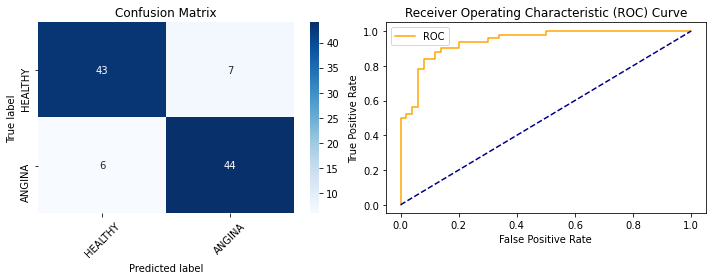

              precision    recall  f1-score   support

     HEALTHY       0.88      0.86      0.87        50
      ANGINA       0.86      0.88      0.87        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

['cov_age', 'cov_sex', 'cov_smoker', 'cov_diabetes', 'cov_hypertens', 'cov_highchol', 'Median_RV_ED', 'Mean_RV_ES', 'Median_RV_ES', 'RootMeanSquared_RV_ES', 'LargeAreaLowGrayLevelEmphasis_glszm_LV_ED', 'LargeAreaLowGrayLevelEmphasis_glszm_MYO_ES', 'LongRunEmphasis_glrlm_MYO_ED', 'RunVariance_glrlm_MYO_ED', 'LargeDependenceEmphasis_gldm_MYO_ED', 'LargeDependenceLowGrayLevelEmphasis_gldm_MYO_ED', 'cov_educ_1.0', 'cov_educ_7.0']


In [102]:
gs, K_best = KBest_GS(X_train_p, y_trainp, X_test_p, y_testp, model_SVC, param_grid_SVC, rad_train)

In [104]:
top15 = pd.Series(abs(gs.best_estimator_.named_steps.model.coef_[0]), index=K_best).nlargest(15)

In [107]:
top15.sort_values(ascending = True, inplace=True)

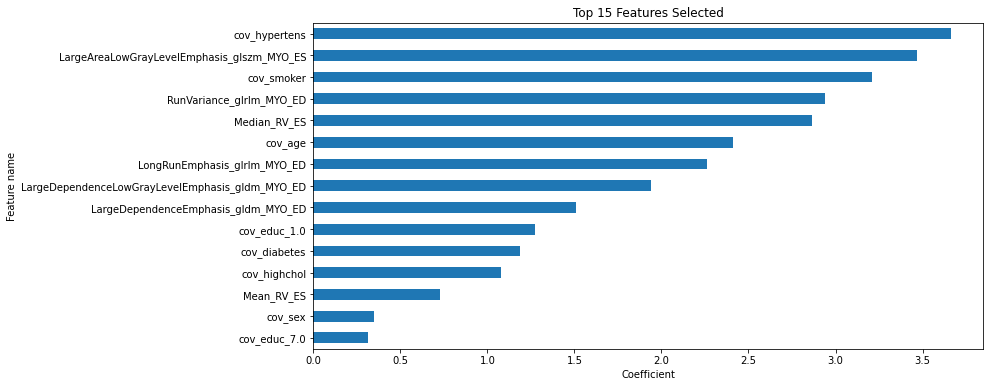

In [108]:
plt.figure(figsize=(12,6))
top15.plot(kind='barh', title='Top 15 Features Selected')
plt.ylabel('Feature name')
plt.xlabel('Coefficient')
plt.show()

In [88]:
#models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

RF_model = RandomForestClassifier(1000)
SVC_model = SVC(C= 0.5, probability=True)
GB_model = GradientBoostingClassifier()
NNC_model = KNeighborsClassifier(2)
AB_model = AdaBoostClassifier(learning_rate=0.5)
NN_model = MLPClassifier(hidden_layer_sizes=(300,))

In [89]:
model_list = [RF_model, SVC_model, GB_model, NNC_model, AB_model, NN_model]

In [90]:
for model in model_list:
    print('--- ', model, '---')
    model.fit(X_train_p, y_trainp)
    y_pred = model.predict(X_test_p)
    print(accuracy_score(y_testp, y_pred))

---  RandomForestClassifier(n_estimators=1000) ---
0.81
---  SVC(C=0.5, probability=True) ---
0.85
---  GradientBoostingClassifier() ---
0.89
---  KNeighborsClassifier(n_neighbors=2) ---
0.8
---  AdaBoostClassifier(learning_rate=0.5) ---
0.87
---  MLPClassifier(hidden_layer_sizes=(300,)) ---
0.86
